In [13]:
import numpy as np
import matplotlib.pyplot as plt

# if this doesn't work try %matplotlib inline
%matplotlib inline

In [14]:
import ukf_voss


**Generate the Data**

In [15]:
nature = ukf_voss.FNNature(ll=1600, dT=0.2, dt=0.02)

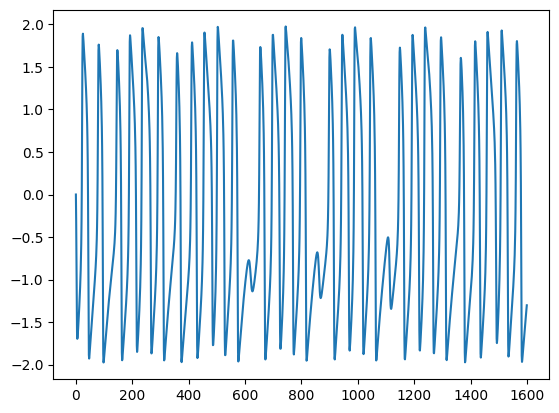

In [16]:
plt.figure()
plt.plot(nature.x0[0, :])

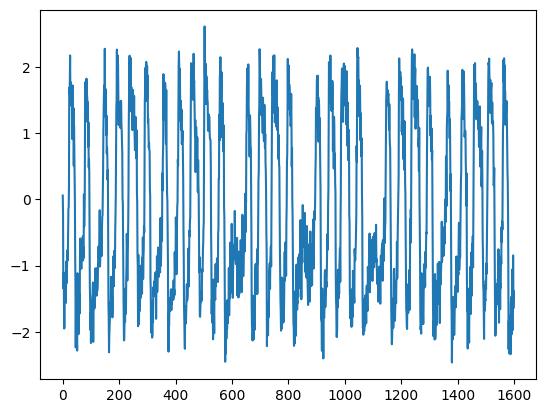

In [17]:
plt.figure()
plt.plot(nature.y[0,:])

## Modifying the FN model for parameter tracking
With this class we can flexibly track the parameers that we want

In [18]:
class FNModel_with_parameter_tracking(ukf_voss.FNModel):
	def __init__(self, a=0.7, b=0.8, c=3., Q_par=0.015, Q_var=np.array((1.,)), R=1., track_a=False, track_b=False, track_c=False):
		super(FNModel_with_parameter_tracking, self).__init__(a, b, c, Q_par, Q_var, R)
		self.track_a = track_a
		self.track_b = track_b
		self.track_c = track_c

	def n_params(self):
		return 1 + int(self.track_a) + int(self.track_b) + int(self.track_c)

	def obs_g_model(self, x):
		return x[self.n_params(), :]

	def f_model(self, x, p):
		a, b, c = self.a, self.b, self.c

		n_p = 1; 
		if self.track_a:
			a = p[n_p, :]
			n_p += 1

		if self.track_b:
			b = p[n_p, :]
			n_p += 1

		if self.track_c:
			c = p[n_p, :]

		x = np.atleast_2d(x)
		# return np.array([c * (x[1,:] + x[0,:] - x[0,:]**3 / 3 + p), -(x[0,:] - a + b * x[1,:]) / c])
		rr = [np.atleast_2d(c * (x[1, :] + x[0, :] - x[0, :] ** 3 / 3 + p[0, :])),
			  np.atleast_2d(-(x[0, :] - a + b * x[1, :]) / c)]
		# print(rr)
		return np.vstack(rr)



### Track c

In [19]:
# define the model
q = 0.015
Q_par = np.diag((q, q))
Q_var0 = np.diag((nature.R, nature.R))
#Define the model used for the Kalman filtering
fn_model = FNModel_with_parameter_tracking(Q_par=Q_par, Q_var=Q_var0, R=nature.R,track_c=True)

In [20]:
#Send to the kalman filter the model we want
uk_filter = ukf_voss.UKFVoss(model=fn_model, ll=1600)

In [ ]:
init = np.array([0.,1, nature.y[0,0], 0.]) #Initial conditions for the KF (p,x) so if you changethe number of parameters you are tracking you need to change this (by default we allways track the current)
#Run the Kalman filter simulation
x_hat0, Pxx0, Ks0, errors0 = uk_filter.filter(nature.y, initial_condition=init)

  0%|          | 0/1599 [00:00<?, ?it/s]

100%|██████████| 1599/1599 [00:04<00:00, 353.96it/s]


In [22]:
def summary_plots():
	plt.figure()
	dq=fn_model.n_params()
	plt.subplot(2, 1, 1)
	plt.plot(nature.y.ravel(), 'bd', markeredgecolor='blue', markerfacecolor='blue', markersize=3)
	plt.plot(nature.x0[0, :], color='black', linewidth=2)
	plt.plot(x_hat0[dq + 0, :], 'r', linewidth=2)
	plt.xlabel('t')
	plt.ylabel('x_1, y')
	plt.title('(a)')
	plt.legend(('observations', 'real x_1', 'estimated x_1'))
	plt.subplot(2, 1, 2)
	plt.plot(nature.x0[1, :], color='black', linewidth=2)
	plt.plot(x_hat0[dq + 1, :], 'r', linewidth=2)
	plt.plot(nature.p[0, :], color='black', linewidth=2)
	colors = 'b', 'g', 'y', 'b'
	for i in range(dq):
		plt.plot(x_hat0[i, :], colors[i], linewidth=2)
	for i in range(dq):
		plt.plot(x_hat0[i, :] + errors0[i, :], colors[i])
	for i in range(dq):
		plt.plot(x_hat0[i, :] - errors0[i, :], colors[i])

	plt.xlabel('t')
	plt.ylabel('z, estimated z, x_2, estimated x_2')
	plt.title('(b)')


	plt.tight_layout()

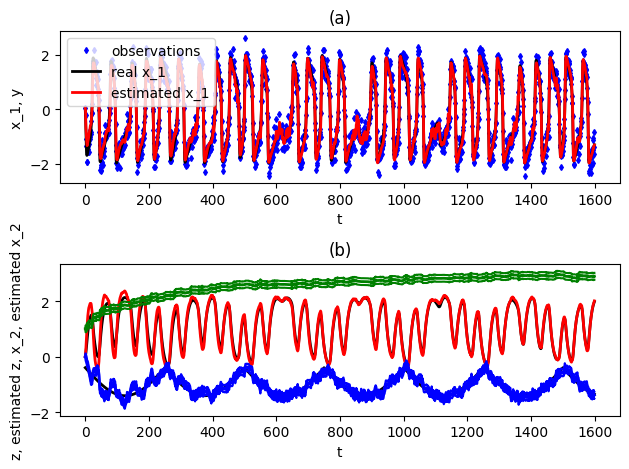

In [23]:
summary_plots()

We assume a_model, b_model = a_nature, b_nature (Also try different and see what happens) \
Graph (a): \
Estimate of the first hidden variable based only on the blue observations \
Graph (b): \
In red estimate of the second hidden state \
In blue the estimate of the current (note we never "see" the actual current values) \
In green the estimate of the parameter c (Starts on our initial guess c=1) \